In [1]:
import pandas as pd 
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

# OPTIVER - Trading At The Close

In [this competition](https://www.kaggle.com/competitions/optiver-trading-at-the-close), you are challenged to develop a model capable of predicting the closing price movements for hundreds of Nasdaq listed stocks using data from the order book and the closing auction of the stock. Information from the auction can be used to adjust prices, assess supply and demand dynamics, and identify trading opportunities. Kagglers are challenged to predict the short term price movements during the 10 minute auction period. 

To help you hit the ground running, we have provided [this tutorial notebook](https://www.kaggle.com/code/tomforbes/optiver-trading-at-the-close-introduction/notebook) that will walk you through the financial concepts and data you will be utilizing to design your model.

In [2]:
df = pd.read_csv(r"data\train.csv", sep = ',')
df

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


In [9]:
df.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   stock_id                 5237980 non-null  int64  
 1   date_id                  5237980 non-null  int64  
 2   seconds_in_bucket        5237980 non-null  int64  
 3   imbalance_size           5237760 non-null  float64
 4   imbalance_buy_sell_flag  5237980 non-null  int64  
 5   reference_price          5237760 non-null  float64
 6   matched_size             5237760 non-null  float64
 7   far_price                2343638 non-null  float64
 8   near_price               2380800 non-null  float64
 9   bid_price                5237760 non-null  float64
 10  bid_size                 5237980 non-null  float64
 11  ask_price                5237760 non-null  float64
 12  ask_size                 5237980 non-null  float64
 13  wap                      5237760 non-null 

- **stock_id**: A unique identifier for the stock. Not all stock IDs exist in every time bucket.
- **date_id**: A unique identifier for the date. Date IDs are sequential & consistent across all stocks.
- **imbalance_size**: The amount unmatched at the current reference price (in USD).
- **imbalance_buy_sell_flag**: An indicator reflecting the direction of auction imbalance.
    - *buy-side imbalance*: 1
    - *sell-side imbalance*: -1
    - *no imbalance*: 0
- **reference_price**: The price at which paired shares are maximized, the imbalance is minimized and the distance from the bid-ask midpoint is minimized, in that order. Can also be thought of as being equal to the near price bounded between the best bid and ask price.
- **matched_size**: The amount that can be matched at the current reference price (in USD).
- **far_price**: The crossing price that will maximize the number of shares matched based on auction interest only. This calculation excludes continuous market orders.
- **near_price**: The crossing price that will maximize the number of shares matched based auction and continuous market orders.
    - **[bid/ask]_price**: Price of the most competitive buy/sell level in the non-auction book.
    - **[bid/ask]_size**: The dollar notional amount on the most competitive buy/sell level in the non-auction book.
    - **wap**: The weighted average price in the non-auction book (BidPrice∗AskSize+AskPrice∗BidSizeBidSize+AskSize)
    
- **seconds_in_bucket**: The number of seconds elapsed since the beginning of the day's closing auction, always starting from 0.
- **target**: The 60 second future move in the wap of the stock, less the 60 second future move of the synthetic index. 
    - The synthetic index is a custom weighted index of Nasdaq-listed stocks constructed by Optiver for this competition.
    - The unit of the target is basis points, which is a common unit of measurement in financial markets. A 1 basis point price move is equivalent to a 0.01% price move.
    - Where t is the time at the current observation, we can define the target:Target=(StockWAPt+60StockWAPt−IndexWAPt+60IndexWAPt)∗10000

All size related columns are in USD terms.

All price related columns are converted to a price move relative to the stock wap (weighted average price) at the beginning of the auction period.

Please refer to https://www.kaggle.com/competitions/optiver-trading-at-the-close/data for specific column definitions.

# 1. Data Analysis

To get an idea of the kind of data we're dealing with, let's look at an elementary time series by filtering on a single stock for a given day.

In [8]:
df_stock_0 = df.query('stock_id == 0 & date_id == 0')
df_stock_0

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
191,0,0,10,1299772.70,1,1.000026,15261106.63,NaN,NaN,0.999812,13996.50,1.000026,23519.16,0.999892,0.389814,1,0_10_0
382,0,0,20,1299772.70,1,0.999919,15261106.63,NaN,NaN,0.999812,4665.50,0.999919,12131.60,0.999842,4.220009,2,0_20_0
573,0,0,30,1299772.70,1,1.000133,15261106.63,NaN,NaN,1.000026,55998.00,1.000133,46203.30,1.000085,5.450249,3,0_30_0
764,0,0,40,1218204.43,1,1.000455,15342674.90,NaN,NaN,1.000241,14655.95,1.000455,26610.45,1.000317,3.169775,4,0_40_0
955,0,0,50,1218204.43,1,1.000455,15342674.90,NaN,NaN,1.000348,42012.00,1.000455,9897.22,1.000434,0.599623,5,0_50_0
1146,0,0,60,1218204.43,1,1.000562,15342674.90,NaN,NaN,1.000455,14005.50,1.000562,10085.04,1.000517,-0.200272,6,0_60_0
1337,0,0,70,1264494.89,1,1.000455,15352380.96,NaN,NaN,1.000348,37904.16,1.000455,17366.82,1.000421,2.410412,7,0_70_0
1528,0,0,80,1189832.86,1,1.000241,15427043.00,NaN,NaN,1.000133,9427.34,1.000241,61984.40,1.000148,-0.389814,8,0_80_0
1719,0,0,90,1189272.89,1,1.000562,15427602.97,NaN,NaN,1.000348,23340.00,1.000562,40433.54,1.000426,-4.339814,9,0_90_0


As we can see, in the first five minutes both the far and near price are not available, as per description of the data.

In [203]:
df.pivot(index=['stock_id','date_id'], columns='seconds_in_bucket', values='reference_price')

seconds_in_bucket       0         10        20        30        40        50   \
stock_id date_id                                                                
0        0         0.999812  1.000026  0.999919  1.000133  1.000455  1.000455   
         1         0.999923  0.999278  0.998634  0.998204  0.998634  0.998634   
         2         0.999968  0.999751  0.999534  0.999425  0.999317  0.999317   
         3         1.000232  0.999907  0.999853  0.999473  0.999798  0.999473   
         4         1.000232  0.999923  1.000644  1.000232  1.000541  1.000438   
...                     ...       ...       ...       ...       ...       ...   
199      476       1.000091  0.999768  0.999768  0.999768  0.999768  0.999768   
         477       1.000231  0.999910  0.999910  0.999910  0.999589  0.999589   
         478       0.999441  1.000081  1.000081  1.000081  1.000081  1.000081   
         479       0.999917  1.000076  0.999600  0.999600  1.000234  1.000393   
         480       1.000859  1.000542  1.000859  1.000859  1.000859  1.000859   

seconds_in_bucket       60        70        80        90   ...       450  \
stock_id date_id                                           ...             
0        0         1.000562  1.000455  1.000241  1.000562  ...  0.999276   
         1         0.998419  0.998849  0.998741  0.998419  ...  0.999278   
         2         0.998774  0.999317  0.999425  0.999751  ...  0.998449   
         3         0.999473  0.999581  0.999690  0.999473  ...  0.998063   
         4         1.000541  1.001778  1.001984  1.001984  ...  1.000232   
...                     ...       ...       ...       ...  ...       ...   
199      476       0.999607  0.999768  0.999768  0.999768  ...  1.000737   
         477       0.999589  0.999910  0.999589  0.999589  ...  0.996384   
         478       1.000081  1.000401  1.000401  1.000401  ...  1.001680   
         479       1.000710  1.000551  1.000551  1.000234  ...  1.003722   
         480       1.000859  1.000859  1.000859  1.000859  ...  1.001812   

seconds_in_bucket       460       470       480       490       500       510  \
stock_id date_id                                                                
0        0         0.999491  0.999383  0.999491  0.999383  0.999491  0.999598   
         1         0.999278  0.999171  0.999601  0.999601  0.999278  0.999171   
         2         0.998449  0.998557  0.998557  0.998449  0.998557  0.998774   
         3         0.997846  0.997737  0.997412  0.997846  0.998171  0.998388   
         4         1.000129  1.000129  0.999717  1.000129  1.000232  1.000129   
...                     ...       ...       ...       ...       ...       ...   
199      476       1.000737  1.000737  1.000737  1.000737  1.000737  1.000737   
         477       0.996063  0.996063  0.996063  0.996384  0.996384  0.996384   
         478       1.001680  1.001680  1.001680  1.001680  1.001680  1.001680   
         479       1.003722  1.003405  1.003405  1.003088  1.003405  1.003405   
         480       1.001812  1.001812  1.001812  1.001812  1.002764  1.002764   

seconds_in_bucket       520       530       540  
stock_id date_id                                 
0        0         0.999598  0.999491  0.999383  
         1         0.999386  0.999601  0.999816  
         2         0.998883  0.998883  0.998557  
         3         0.998280  0.998388  0.998280  
         4         1.000129  1.000129  1.000129  
...                     ...       ...       ...  
199      476       1.000737  1.000737  1.000737  
         477       0.996384  0.996704  0.996704  
         478       1.001680  1.001680  1.001680  
         479       1.003405  1.003405  1.003405  
         480       1.001812  1.001812  1.002129  

[95236 rows x 55 columns]

## Features Correlation

Let's dive more into the correlation among these features, using the Pearson correlation:

C:\Users\ZERO\AppData\Local\Temp\ipykernel_7908\3279455266.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = df.corr(method='pearson')


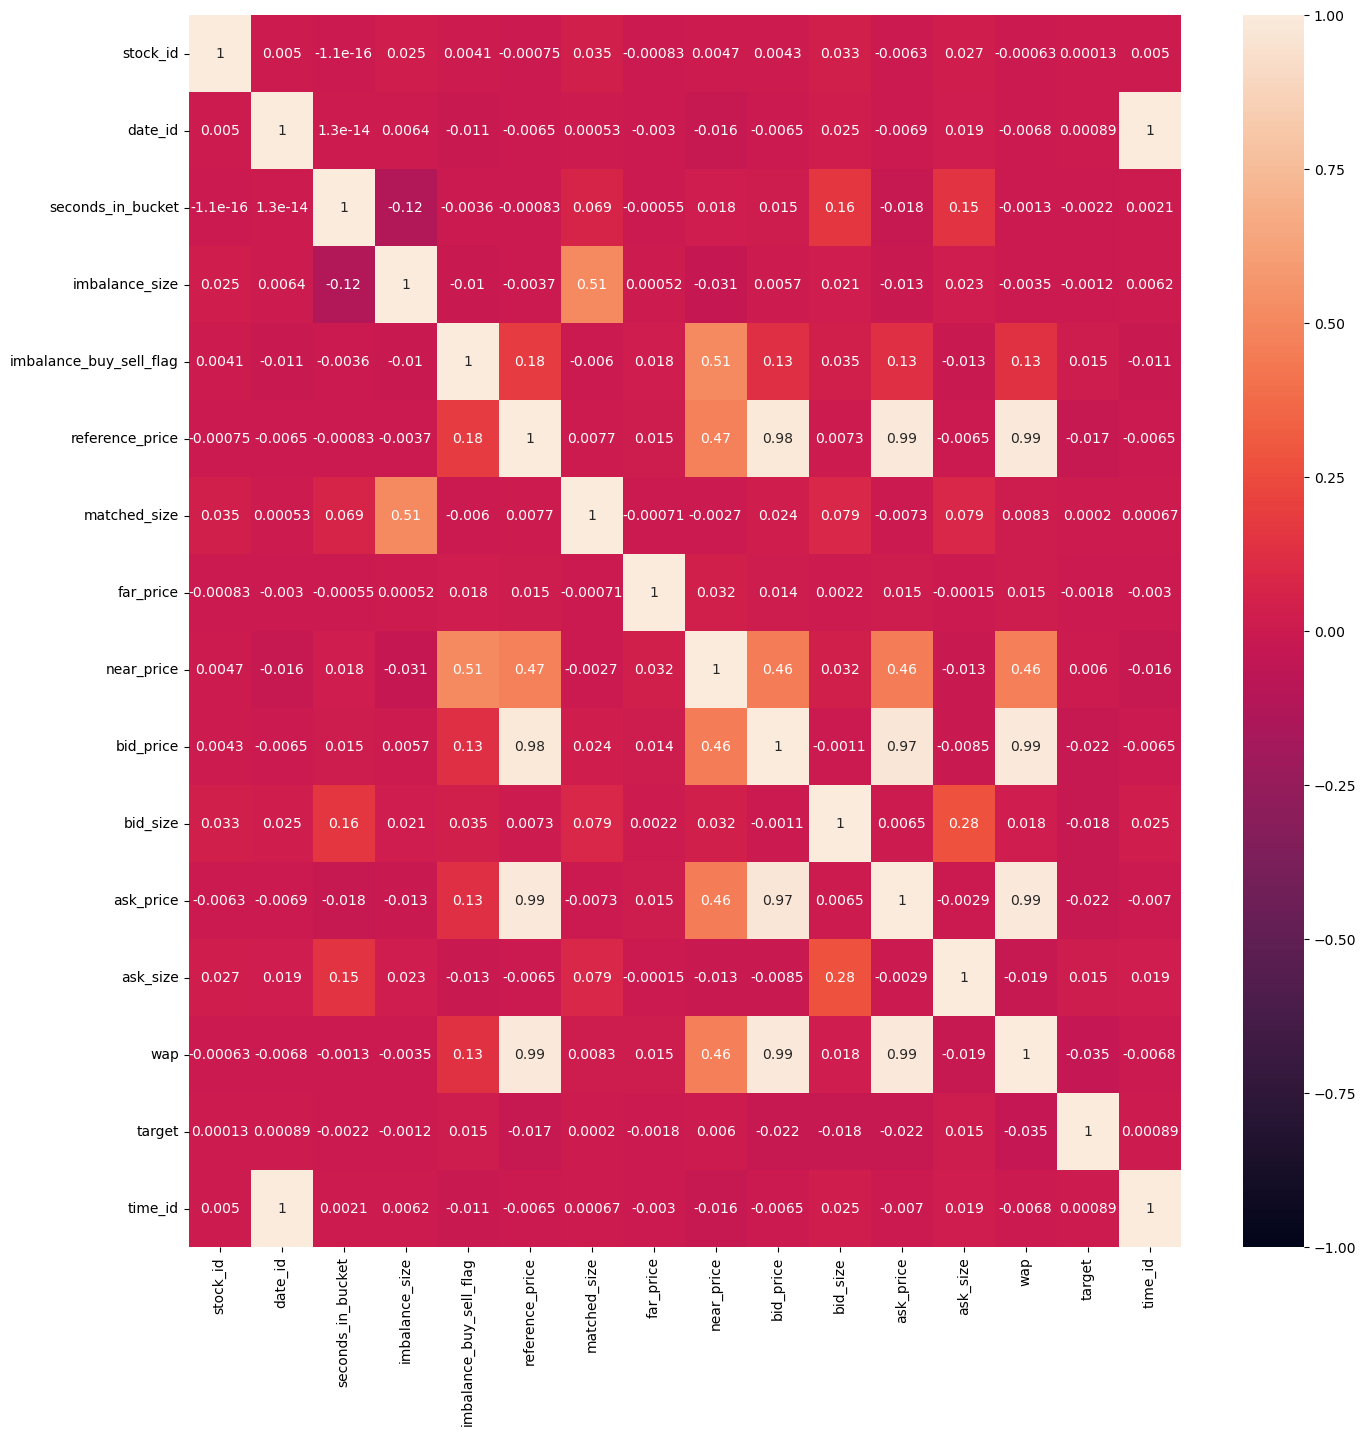

In [13]:
plt.figure(figsize=(16,16))
cor = df.corr(method='pearson')
sns.heatmap(cor, vmin=-1, vmax=1, annot=True)
plt.show()

Interesting facts can be drawn from this correlation grid:
- **reference_price**, **ask_price**, **bid_price**, **wap** are all highly interrelated among each other (0.98-0.99): this is something we expect, as long as *"reference_price"* is the final price, and it's always included between the *"ask_price"* (selling - lowest higher one) and the *"bid_price"* (buying - highest lower one). On the other hand, *"wap"* is a calculated field, directly derived from *"bid_price"* and *"ask_price"*.
- **near_price** has a positive correlation of 0.46 with **ask/bid/reference_price**, **imbalance_buy_sell_flag** has a positive correlation of 0.51 with **near_price**, but correlation between **imbalance_buy_sell_flag** and **ask/bid/reference_price** is only 0.13.
- **imbalance_size** has a positive correlation of 0.51 with **matched_size**: this is due to the fact that the imbalance is derived directly from the matched_size, positively or negatively according to the position of imbalance (towards selling or buying part).
- **bid_size** has a positive correlation of 0.28 with **ask_size**.


Since *"far_price"* and *"near_price"* are always null in the first five minutes, let's check correlations in the timeframe 5-9 minutes.

In [24]:
df_5_9_min = df.loc[df['seconds_in_bucket'] >= 300]
df_5_9_min

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
5730,0,0,300,0.00,0,1.000241,26670118.88,1.000241,1.000241,1.000026,19319.31,1.000241,16149.55,1.000143,-10.039806,30,0_300_0
5731,1,0,300,242332.96,-1,1.000073,3242054.27,0.981974,0.994490,0.999544,43205.40,1.000308,2042.76,1.000273,-1.329780,30,0_300_1
5732,2,0,300,0.00,0,1.000193,4671376.00,1.000193,1.000193,0.999035,18971.00,1.001036,59688.26,0.999518,14.009476,30,0_300_2
5733,3,0,300,2914730.16,1,0.999870,41057776.66,1.003870,1.002279,0.999827,25569.50,1.000042,37897.50,0.999914,-4.339814,30,0_300_3
5734,4,0,300,3396923.02,1,0.998496,38356174.88,1.007894,1.007894,0.998357,14446.00,0.998703,2601.18,0.998650,10.850430,30,0_300_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


C:\Users\ZERO\AppData\Local\Temp\ipykernel_7908\1499292306.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = df_5_9_min.corr(method='pearson')


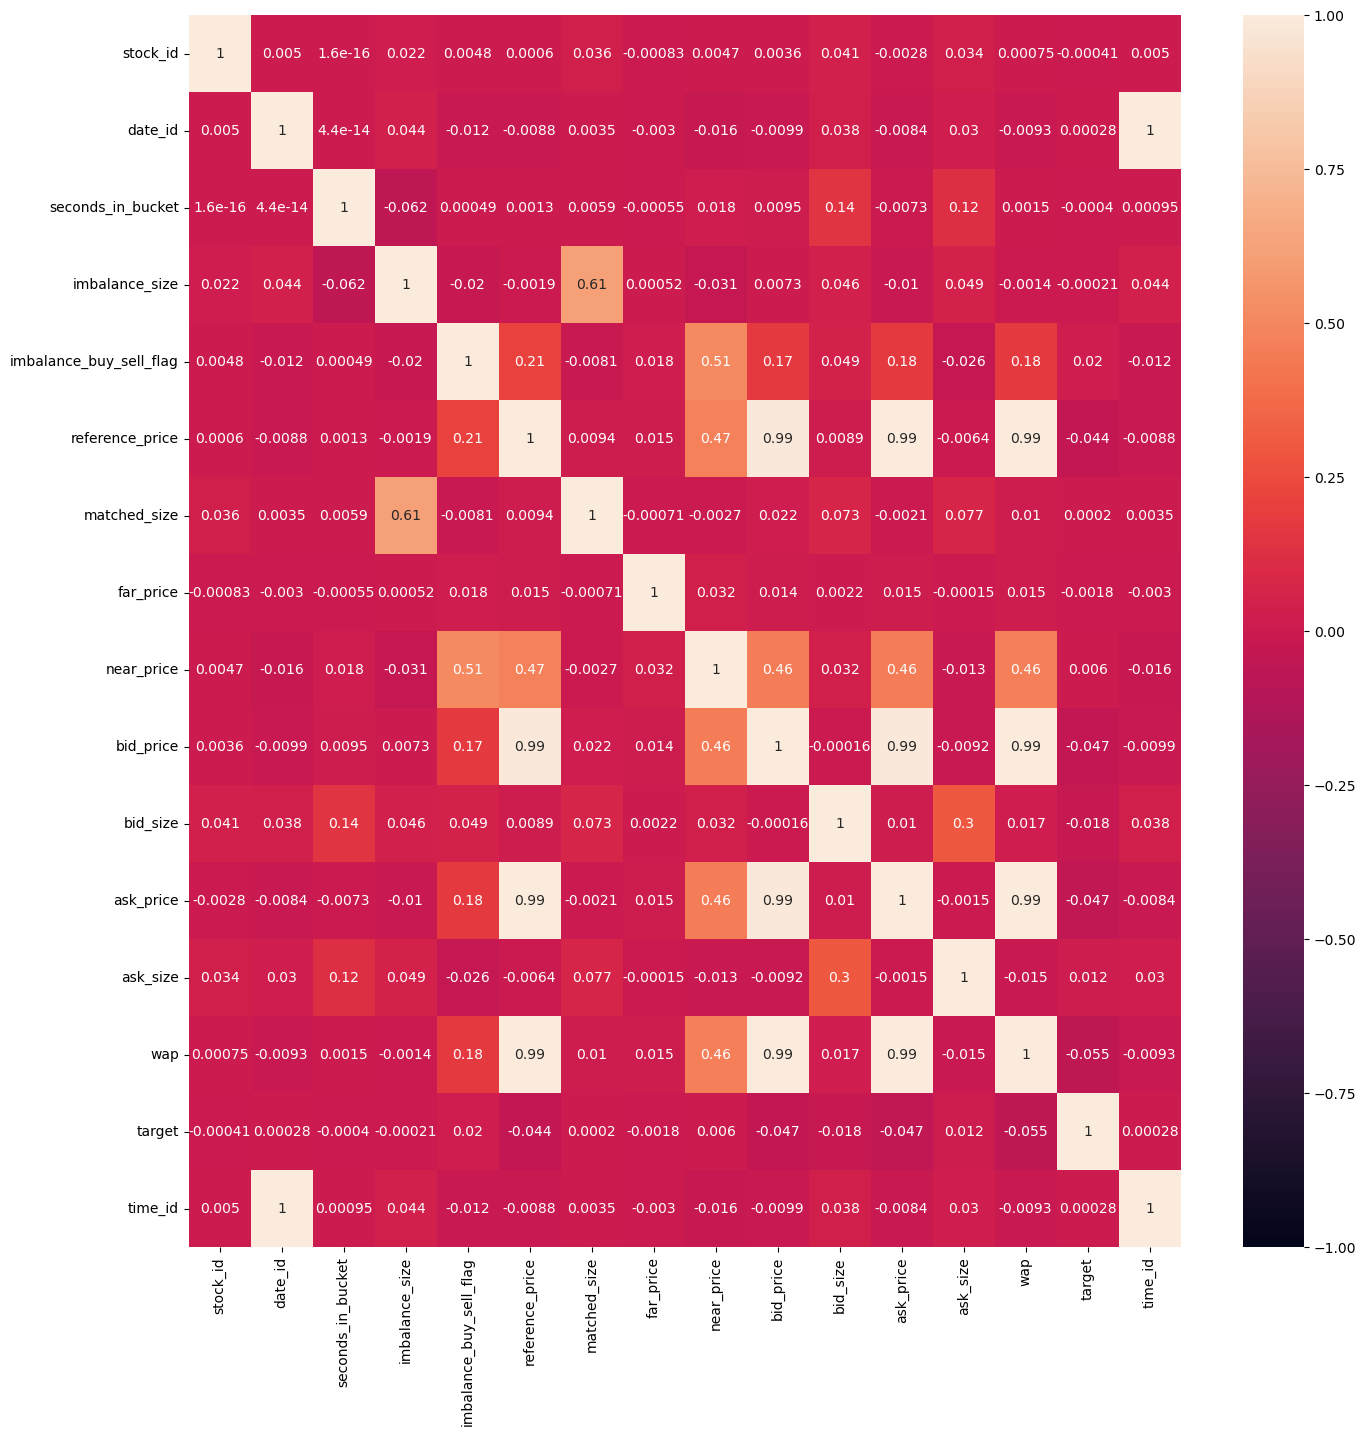

In [25]:
plt.figure(figsize=(16,16))
cor = df_5_9_min.corr(method='pearson')
sns.heatmap(cor, vmin=-1, vmax=1, annot=True)
plt.show()

Variations in numbers are negligible.

In [ ]:
#acf/pacf

# 2. Data Preprocessing

In [84]:
filtered_df = df.copy(deep=True)
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 679.4+ MB


In [85]:
filtered_df['stock_id'].value_counts().value_counts()

26455    189
26400      2
24420      2
26235      1
23210      1
22605      1
21615      1
16500      1
15950      1
10230      1
Name: stock_id, dtype: int64

The distribution of records for each stock is not equal. Most stocks (189) have 26k records, 11 have between 26400 and 10230 records (even much less). 

Let's slice out stocks that have a partial amount of records. 

In [86]:
vc = filtered_df['stock_id'].value_counts()
filtered_df = filtered_df[filtered_df['stock_id'].isin(vc[vc == 26455].index)]
filtered_df

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237974,194,480,540,262271.52,-1,1.001504,3922295.41,1.000677,1.000677,1.001504,20829.20,1.001917,139637.49,1.001557,4.839897,26454,480_540_194
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197


In [89]:
filtered_df['date_id'].value_counts().value_counts()

10395    481
Name: date_id, dtype: int64

Every stock in this slice has the same amount of dates.

In [94]:
filtered_df.groupby('stock_id')['seconds_in_bucket'].nunique().value_counts()

55    189
Name: seconds_in_bucket, dtype: int64

Every stock in this slice has the same amount of minute values per day (from 0 to 540 at a step of 10).

## Null Values Wrangling

In [95]:
print(len(filtered_df))
filtered_df.isnull().sum(axis=0)

4999995


stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2761627
near_price                 2727370
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

By limiting the time series to the minutes between 5 and 9, we should remove most of the null values, due to the missing *"far_price"* and *"near_price"*.

In [98]:
filtered_df_59 = filtered_df[filtered_df['seconds_in_bucket'] >= 300]
filtered_df_59

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
5730,0,0,300,0.00,0,1.000241,26670118.88,1.000241,1.000241,1.000026,19319.31,1.000241,16149.55,1.000143,-10.039806,30,0_300_0
5731,1,0,300,242332.96,-1,1.000073,3242054.27,0.981974,0.994490,0.999544,43205.40,1.000308,2042.76,1.000273,-1.329780,30,0_300_1
5732,2,0,300,0.00,0,1.000193,4671376.00,1.000193,1.000193,0.999035,18971.00,1.001036,59688.26,0.999518,14.009476,30,0_300_2
5733,3,0,300,2914730.16,1,0.999870,41057776.66,1.003870,1.002279,0.999827,25569.50,1.000042,37897.50,0.999914,-4.339814,30,0_300_3
5734,4,0,300,3396923.02,1,0.998496,38356174.88,1.007894,1.007894,0.998357,14446.00,0.998703,2601.18,0.998650,10.850430,30,0_300_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237974,194,480,540,262271.52,-1,1.001504,3922295.41,1.000677,1.000677,1.001504,20829.20,1.001917,139637.49,1.001557,4.839897,26454,480_540_194
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197


In [99]:
print(len(filtered_df_59))
filtered_df_59.isnull().sum(axis=0)

2272725


stock_id                       0
date_id                        0
seconds_in_bucket              0
imbalance_size               100
imbalance_buy_sell_flag        0
reference_price              100
matched_size                 100
far_price                  34357
near_price                   100
bid_price                    100
bid_size                       0
ask_price                    100
ask_size                       0
wap                          100
target                        26
time_id                        0
row_id                         0
dtype: int64

In [100]:
print(len(filtered_df_59))
filtered_df_59.isnull().sum(axis=1).value_counts()

2272725


0    2238368
1      34257
8         74
9         26
dtype: int64

There are some records that accumulate up to 8 and 9 null values. Let's check them out.

In [101]:
filtered_df_59[filtered_df_59.isnull().sum(axis=1) > 1]

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
375268,131,35,300,NaN,0,NaN,NaN,NaN,NaN,NaN,75210.50,NaN,33462.00,NaN,90.130570,1955,35_300_131
375460,131,35,310,NaN,0,NaN,NaN,NaN,NaN,NaN,75210.50,NaN,39468.00,NaN,3.499985,1956,35_310_131
375652,131,35,320,NaN,0,NaN,NaN,NaN,NaN,NaN,75210.50,NaN,39468.00,NaN,1.239777,1957,35_320_131
375844,131,35,330,NaN,0,NaN,NaN,NaN,NaN,NaN,75210.50,NaN,39468.00,NaN,0.979900,1958,35_330_131
376036,131,35,340,NaN,0,NaN,NaN,NaN,NaN,NaN,75210.50,NaN,39468.00,NaN,-0.050068,1959,35_340_131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4774999,19,438,500,NaN,-1,NaN,NaN,NaN,NaN,NaN,115491.18,NaN,1990.10,NaN,3.319979,24140,438_500_19
4775199,19,438,510,NaN,-1,NaN,NaN,NaN,NaN,NaN,189040.50,NaN,26283.84,NaN,-5.049705,24141,438_510_19
4775399,19,438,520,NaN,-1,NaN,NaN,NaN,NaN,NaN,1392.93,NaN,43799.80,NaN,-0.110269,24142,438_520_19
4775599,19,438,530,NaN,-1,NaN,NaN,NaN,NaN,NaN,13531.32,NaN,26881.20,NaN,-1.689792,24143,438_530_19


In [105]:
filtered_df_59.loc[filtered_df_59.isnull().sum(axis=1) > 1, ['stock_id', 'date_id']].value_counts()

stock_id  date_id
19        438        25
101       328        25
131       35         25
158       388        25
dtype: int64

The affected stocks are:
- stock 19 on day 438
- stock 101 on day 328
- stock 131 on day 35
- stock 158 on day 388 


For the moment we're going to remove any stock affected by potential issues like this one.

In [114]:
filtered_df_59 = filtered_df_59[~ filtered_df_59['stock_id'].isin([19, 101, 131, 158])]
filtered_df_59

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
5730,0,0,300,0.00,0,1.000241,26670118.88,1.000241,1.000241,1.000026,19319.31,1.000241,16149.55,1.000143,-10.039806,30,0_300_0
5731,1,0,300,242332.96,-1,1.000073,3242054.27,0.981974,0.994490,0.999544,43205.40,1.000308,2042.76,1.000273,-1.329780,30,0_300_1
5732,2,0,300,0.00,0,1.000193,4671376.00,1.000193,1.000193,0.999035,18971.00,1.001036,59688.26,0.999518,14.009476,30,0_300_2
5733,3,0,300,2914730.16,1,0.999870,41057776.66,1.003870,1.002279,0.999827,25569.50,1.000042,37897.50,0.999914,-4.339814,30,0_300_3
5734,4,0,300,3396923.02,1,0.998496,38356174.88,1.007894,1.007894,0.998357,14446.00,0.998703,2601.18,0.998650,10.850430,30,0_300_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237974,194,480,540,262271.52,-1,1.001504,3922295.41,1.000677,1.000677,1.001504,20829.20,1.001917,139637.49,1.001557,4.839897,26454,480_540_194
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197


In [116]:
filtered_df_59.isna().sum(axis=0)

stock_id                       0
date_id                        0
seconds_in_bucket              0
imbalance_size                 0
imbalance_buy_sell_flag        0
reference_price                0
matched_size                   0
far_price                  33086
near_price                     0
bid_price                      0
bid_size                       0
ask_price                      0
ask_size                       0
wap                            0
target                         0
time_id                        0
row_id                         0
dtype: int64

Let's take a look at far_price null-valued records.

In [141]:
stats = filtered_df_59[filtered_df_59['far_price'].isna()][['stock_id', 'date_id', 'seconds_in_bucket']]
stats

,stock_id,date_id,seconds_in_bucket
5763,33,0,300
5803,74,0,300
5816,89,0,300
5818,91,0,300
5954,33,0,310
...,...,...,...
5236124,144,480,450
5236151,171,480,450
5236167,187,480,450
5236240,60,480,460


In [154]:
stats['seconds_in_bucket'].value_counts()


300    3831
310    2324
320    2240
330    2194
340    2121
350    2096
360    2078
370    2024
380    1989
390    1961
400    1919
410    1889
420    1847
430    1734
440    1349
450     931
460     288
470     138
480      21
490      19
500      19
510      19
520      19
530      19
540      17
Name: seconds_in_bucket, dtype: int64

In [175]:
stats['stock_id'].value_counts().head(50)

143    1400
86      919
11      843
31      756
174     599
129     578
70      525
82      524
155     523
66      492
125     483
71      466
18      435
159     425
21      399
107     389
97      386
43      375
92      371
170     353
98      346
94      344
80      341
165     335
117     335
146     325
134     316
120     314
111     314
188     308
100     297
64      294
114     277
26      276
167     275
108     265
145     261
181     260
85      260
62      242
1       241
25      237
51      237
161     233
119     231
42      230
177     228
172     227
147     223
48      222
Name: stock_id, dtype: int64

In [197]:
filtered_df_59[filtered_df_59['stock_id'] == 159]


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
5881,159,0,300,737156.51,-1,0.996520,6015133.95,0.975139,0.986383,0.996520,4026.88,0.996836,6356.94,0.996643,-4.100204,30,0_300_159
6072,159,0,310,652296.69,-1,0.996361,6099993.77,0.976722,0.990185,0.996361,18306.81,0.996678,26619.39,0.996490,-1.800060,31,0_310_159
6263,159,0,320,633354.77,-1,0.996520,6118935.69,0.976722,0.991293,0.996520,47882.12,0.996678,50155.21,0.996597,-9.819865,32,0_320_159
6454,159,0,330,633354.77,-1,0.996361,6118935.69,0.976722,0.990660,0.996361,34789.23,0.996520,25797.20,0.996452,-8.789897,33,0_330_159
6645,159,0,340,624767.76,-1,0.996045,6127522.70,0.976722,0.987651,0.996045,6100.33,0.996203,35286.90,0.996068,-1.789927,34,0_340_159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237139,159,480,500,323641.54,-1,1.001228,22645967.12,1.000372,1.000942,1.001228,42334.62,1.001418,91215.78,1.001288,-2.700090,26450,480_500_159
5237339,159,480,510,351830.01,-1,1.001323,22628296.74,1.000372,1.001133,1.001228,50338.18,1.001323,21274.64,1.001295,-3.859997,26451,480_510_159
5237539,159,480,520,323641.54,-1,1.001228,22645967.12,1.000372,1.001133,1.001228,32224.86,1.001323,97421.00,1.001251,1.850128,26452,480_520_159
5237739,159,480,530,316804.78,-1,1.001228,22652803.88,1.000372,1.001133,1.001228,72558.59,1.001323,139654.32,1.001260,4.969835,26453,480_530_159


In [198]:
filtered_df_59[filtered_df_59['far_price'].isna()]


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
5763,33,0,300,3092376.98,-1,0.997339,8978868.85,NaN,0.958708,0.996829,16547.96,0.997922,18345.94,0.997348,6.040335,30,0_300_33
5803,74,0,300,10011877.82,-1,0.998111,25349282.16,NaN,0.939632,0.998111,698.76,0.999197,6295.68,0.998220,-12.279749,30,0_300_74
5816,89,0,300,3752394.06,-1,0.998701,8351193.72,NaN,0.951207,0.997631,30906.00,0.999030,3034.25,0.998905,-12.260079,30,0_300_89
5818,91,0,300,9722538.89,1,1.001756,19001042.87,NaN,1.030012,1.001926,10030.68,1.002605,295.22,1.002586,-17.600060,30,0_300_91
5954,33,0,310,2974526.41,-1,0.996829,9096719.42,NaN,0.962498,0.996829,52242.32,0.997047,70310.06,0.996922,8.230209,31,0_310_33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5236124,144,480,450,9083704.04,-1,0.998723,27319450.26,NaN,0.900102,0.998723,8798.61,0.998845,90052.80,0.998734,2.839565,26445,480_450_144
5236151,171,480,450,7389482.22,-1,0.999281,22202291.97,NaN,0.950294,0.999371,13216.00,0.999460,22514.01,0.999404,0.070333,26445,480_450_171
5236167,187,480,450,8083304.67,1,1.000180,29493925.41,NaN,1.038808,1.000026,30150.72,1.000180,11178.28,1.000138,-4.169941,26445,480_450_187
5236240,60,480,460,29976877.98,-1,0.990839,75750325.85,NaN,0.949708,0.990771,44953.10,0.990839,40315.56,0.990807,-2.679825,26446,480_460_60


In [199]:
filtered_df_59.query('stock_id == 171 & date_id == 480')


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
5233151,171,480,300,9240326.97,-1,1.000174,20351447.23,NaN,0.900147,0.999817,16023.15,1.000174,15468.42,0.999998,-3.139973,26430,480_300_171
5233351,171,480,310,8188993.36,-1,0.999995,21402780.83,NaN,0.919064,0.999817,9860.40,0.999995,46845.26,0.999848,-3.769994,26431,480_310_171
5233551,171,480,320,8154587.71,-1,0.999549,21437186.49,NaN,0.917101,0.999549,20051.58,0.999638,17812.77,0.999596,-2.080202,26432,480_320_171
5233751,171,480,330,8154587.71,-1,0.999281,21437186.49,NaN,0.915316,0.999371,14336.00,0.999460,33603.00,0.999397,-1.400113,26433,480_330_171
5233951,171,480,340,8121078.62,-1,0.999281,21470695.57,NaN,0.919064,0.999281,48043.71,0.999371,16800.00,0.999348,-1.249909,26434,480_340_171
5234151,171,480,350,8121078.62,-1,0.999371,21470695.57,NaN,0.919064,0.999281,20830.14,0.999460,5712.51,0.999422,1.820326,26435,480_350_171
5234351,171,480,360,8108975.00,-1,0.999728,21482799.19,NaN,0.919064,0.999638,20277.43,0.999728,5714.04,0.999708,-0.110269,26436,480_360_171
5234551,171,480,370,8083983.27,-1,0.999192,21507790.92,NaN,0.922633,0.999192,17916.80,0.999371,11200.00,0.999302,2.419949,26437,480_370_171
5234751,171,480,380,8071095.16,-1,0.999281,21520679.03,NaN,0.922633,0.999281,1903.83,0.999371,33600.00,0.999286,1.109838,26438,480_380_171
5234951,171,480,390,8071095.16,-1,0.999103,21520679.03,NaN,0.922633,0.999103,63822.90,0.999192,27883.02,0.999165,3.620386,26439,480_390_171


In [195]:
filtered_df_59.query('stock_id == 159 & date_id == 3')


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
37396,159,3,300,3389330.92,1,1.001464,6680170.88,NaN,1.042615,1.002115,20885.79,1.002765,19111.50,1.002454,-0.900030,195,3_300_159
37587,159,3,310,3045473.28,1,1.003090,7024028.52,NaN,1.041477,1.002765,39332.70,1.003090,6167.00,1.003046,-4.379749,196,3_310_159
37778,159,3,320,3027029.28,1,1.003090,7042472.52,NaN,1.041477,1.002765,57827.70,1.003090,12334.00,1.003033,-8.890033,197,3_320_159
37969,159,3,330,3025369.32,1,1.003090,7044132.48,NaN,1.041477,1.002928,83117.68,1.003090,33856.83,1.003043,-8.209944,198,3_330_159
38160,159,3,340,3005634.24,1,1.002928,7063867.56,NaN,1.041477,1.002765,73486.80,1.002928,23245.82,1.002889,-8.130074,199,3_340_159
38351,159,3,350,2966164.08,1,1.002440,7103337.72,NaN,1.039688,1.002277,24648.00,1.002440,5546.70,1.002410,-7.560253,200,3_350_159
38542,159,3,360,2929276.08,1,1.002440,7140225.72,NaN,1.039688,1.002115,41894.80,1.002440,3204.76,1.002417,-10.669827,201,3_360_159
38733,159,3,370,2927308.72,1,1.002765,7142193.08,NaN,1.040989,1.002440,17441.29,1.002765,8014.50,1.002663,-10.480285,202,3_370_159
38924,159,3,380,2885133.44,1,1.002277,7184368.36,NaN,1.038061,1.002115,58529.50,1.002277,2649.66,1.002270,-3.910065,203,3_380_159
39115,159,3,390,2882243.88,1,1.002440,7187257.92,NaN,1.037411,1.002277,43134.00,1.002440,32787.16,1.002370,-5.670190,204,3_390_159


In [31]:
df_5_9_min = df.loc[df['seconds_in_bucket'] >= 300]
df_5_9_min.drop(columns = ['row_id'], inplace = True)

C:\Users\ZERO\AppData\Local\Temp\ipykernel_7908\1059772300.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5_9_min.drop(columns = ['row_id'], inplace = True)


In [32]:
print(len(df_5_9_min))
df_5_9_min.isnull().sum(axis=0)

2380900


stock_id                       0
date_id                        0
seconds_in_bucket              0
imbalance_size               100
imbalance_buy_sell_flag        0
reference_price              100
matched_size                 100
far_price                  37262
near_price                   100
bid_price                    100
bid_size                       0
ask_price                    100
ask_size                       0
wap                          100
target                        26
time_id                        0
dtype: int64

In [11]:
df_5_9_min.loc[pd.isna(df_5_9_min['far_price'])]

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
5763,33,0,300,3092376.98,-1,0.997339,8978868.85,NaN,0.958708,0.996829,16547.96,0.997922,18345.94,0.997348,6.040335,30
5803,74,0,300,10011877.82,-1,0.998111,25349282.16,NaN,0.939632,0.998111,698.76,0.999197,6295.68,0.998220,-12.279749,30
5816,89,0,300,3752394.06,-1,0.998701,8351193.72,NaN,0.951207,0.997631,30906.00,0.999030,3034.25,0.998905,-12.260079,30
5818,91,0,300,9722538.89,1,1.001756,19001042.87,NaN,1.030012,1.001926,10030.68,1.002605,295.22,1.002586,-17.600060,30
5954,33,0,310,2974526.41,-1,0.996829,9096719.42,NaN,0.962498,0.996829,52242.32,0.997047,70310.06,0.996922,8.230209,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5236124,144,480,450,9083704.04,-1,0.998723,27319450.26,NaN,0.900102,0.998723,8798.61,0.998845,90052.80,0.998734,2.839565,26445
5236151,171,480,450,7389482.22,-1,0.999281,22202291.97,NaN,0.950294,0.999371,13216.00,0.999460,22514.01,0.999404,0.070333,26445
5236167,187,480,450,8083304.67,1,1.000180,29493925.41,NaN,1.038808,1.000026,30150.72,1.000180,11178.28,1.000138,-4.169941,26445
5236240,60,480,460,29976877.98,-1,0.990839,75750325.85,NaN,0.949708,0.990771,44953.10,0.990839,40315.56,0.990807,-2.679825,26446


In [12]:
df_5_9_min.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2380900 entries, 5730 to 5237979
Data columns (total 16 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
dtypes: float64(11), int64(5)
memory usage: 308.8 MB


In [13]:
df_5_9_filled = df_5_9_min.groupby(['stock_id', 'date_id'], group_keys=False).apply(lambda s: s.interpolate())

In [14]:
df_5_9_filled.loc[pd.isna(df_5_9_min['far_price'])]

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
5763,33,0,300,3092376.98,-1,0.997339,8978868.85,NaN,0.958708,0.996829,16547.96,0.997922,18345.94,0.997348,6.040335,30
5803,74,0,300,10011877.82,-1,0.998111,25349282.16,NaN,0.939632,0.998111,698.76,0.999197,6295.68,0.998220,-12.279749,30
5816,89,0,300,3752394.06,-1,0.998701,8351193.72,NaN,0.951207,0.997631,30906.00,0.999030,3034.25,0.998905,-12.260079,30
5818,91,0,300,9722538.89,1,1.001756,19001042.87,NaN,1.030012,1.001926,10030.68,1.002605,295.22,1.002586,-17.600060,30
5954,33,0,310,2974526.41,-1,0.996829,9096719.42,NaN,0.962498,0.996829,52242.32,0.997047,70310.06,0.996922,8.230209,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5236124,144,480,450,9083704.04,-1,0.998723,27319450.26,NaN,0.900102,0.998723,8798.61,0.998845,90052.80,0.998734,2.839565,26445
5236151,171,480,450,7389482.22,-1,0.999281,22202291.97,NaN,0.950294,0.999371,13216.00,0.999460,22514.01,0.999404,0.070333,26445
5236167,187,480,450,8083304.67,1,1.000180,29493925.41,NaN,1.038808,1.000026,30150.72,1.000180,11178.28,1.000138,-4.169941,26445
5236240,60,480,460,29976877.98,-1,0.990839,75750325.85,NaN,0.949708,0.990771,44953.10,0.990839,40315.56,0.990807,-2.679825,26446


In [15]:
df_5_9_filled = df_5_9_min.groupby(['stock_id', 'date_id'], group_keys=False).apply(lambda s: (s.ffill().astype(float)+s.bfill().astype(float))/2)

In [16]:
df_5_9_filled

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
5730,0.0,0.0,300.0,0.00,0.0,1.000241,26670118.88,1.000241,1.000241,1.000026,19319.31,1.000241,16149.55,1.000143,-10.039806,30.0
5731,1.0,0.0,300.0,242332.96,-1.0,1.000073,3242054.27,0.981974,0.994490,0.999544,43205.40,1.000308,2042.76,1.000273,-1.329780,30.0
5732,2.0,0.0,300.0,0.00,0.0,1.000193,4671376.00,1.000193,1.000193,0.999035,18971.00,1.001036,59688.26,0.999518,14.009476,30.0
5733,3.0,0.0,300.0,2914730.16,1.0,0.999870,41057776.66,1.003870,1.002279,0.999827,25569.50,1.000042,37897.50,0.999914,-4.339814,30.0
5734,4.0,0.0,300.0,3396923.02,1.0,0.998496,38356174.88,1.007894,1.007894,0.998357,14446.00,0.998703,2601.18,0.998650,10.850430,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195.0,480.0,540.0,2440722.89,-1.0,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454.0
5237976,196.0,480.0,540.0,349510.47,-1.0,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454.0
5237977,197.0,480.0,540.0,0.00,0.0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454.0
5237978,198.0,480.0,540.0,1000898.84,1.0,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454.0


In [17]:
def fill_NaN(s: pd.Series) -> pd.Series:
    s_bfill = s.bfill()
    s_ffill = s.ffill()
    s_bfill = s_bfill.fillna(s_ffill)
    s_ffill = s_ffill.fillna(s_bfill)
    
    return (s_bfill + s_ffill)/2

In [18]:
df_5_9_filled = pd.DataFrame()
for colonna in tqdm(df_5_9_min.columns[2:]):
    df_5_9_filled[colonna] = df_5_9_min[['stock_id', 'date_id', colonna]].groupby(['stock_id', 'date_id'], group_keys=True).apply(lambda s: fill_NaN(s[colonna]))

#df_5_9_filled = df_5_9_min.groupby(['stock_id', 'date_id'], group_keys=False).apply(lambda s: fill_NaN(s))

100%|█████████████████████████████████████████████████████████████████████████████████| 14/14 [34:26<00:00, 147.64s/it]


In [20]:
df_5_9_filled.to_csv(r'data\df_5_9_filled_V1.csv', sep=',')

In [ ]:
df_5_9_filled

In [85]:
df_merge_prova = pd.merge(df_5_9_min[['stock_id', 'date_id']], df_5_9_filled,
                          left_index=True,
                          right_index=True)

In [87]:
df_merge_prova.loc[pd.isna(df_merge_prova['far_price'])]

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
227377,78,21,300.0,2180217.61,1.0,1.014278,2648727.34,NaN,1.024576,1.013820,4651.50,1.015651,19438.44,1.014174,2.750158,1185.0
227569,78,21,310.0,1872465.88,1.0,1.015880,2775664.55,NaN,1.022059,1.015193,37306.76,1.016109,178266.00,1.015352,-27.819872,1186.0
227761,78,21,320.0,1859357.04,1.0,1.016566,2788773.39,NaN,1.024347,1.015880,16424.30,1.016566,189895.50,1.015934,-32.629967,1187.0
227953,78,21,330.0,1822215.35,1.0,1.015880,2825915.08,NaN,1.022974,1.014278,17816.64,1.016109,57409.20,1.014712,-15.550256,1188.0
228145,78,21,340.0,1822215.35,1.0,1.016338,2825915.08,NaN,1.025263,1.015193,6299.12,1.016566,27362.72,1.015450,-35.300255,1189.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5204123,143,477,500.0,255151.04,1.0,1.004842,255515.84,NaN,1.004842,0.998483,283584.39,1.004842,580601.02,1.000579,-8.919835,26285.0
5204323,143,477,510.0,255151.04,1.0,1.004842,255515.84,NaN,1.004842,0.998483,282171.39,1.004842,579806.28,1.000573,-5.769730,26286.0
5204523,143,477,520.0,255151.04,1.0,1.004842,255515.84,NaN,1.004842,0.998483,288765.39,1.004842,578066.70,1.000610,-7.150173,26287.0
5204723,143,477,530.0,255151.04,1.0,1.004842,255515.84,NaN,1.004842,0.998483,287363.38,1.004842,578066.70,1.000603,-9.520054,26288.0


In [90]:
df_5_9_filled.loc[pd.isna(df_5_9_filled['far_price'])]

seconds_in_bucket  imbalance_size  \
stock_id date_id                                              
19       438     4770999              300.0             NaN   
                 4771199              310.0             NaN   
                 4771399              320.0             NaN   
                 4771599              330.0             NaN   
                 4771799              340.0             NaN   
...                                     ...             ...   
158      388     4225138              500.0             NaN   
                 4225338              510.0             NaN   
                 4225538              520.0             NaN   
                 4225738              530.0             NaN   
                 4225938              540.0             NaN   

                          imbalance_buy_sell_flag  reference_price  \
stock_id date_id                                                     
19       438     4770999                     -1.0              NaN   
                 4771199                     -1.0              NaN   
                 4771399                     -1.0              NaN   
                 4771599                     -1.0              NaN   
                 4771799                     -1.0              NaN   
...                                           ...              ...   
158      388     4225138                      0.0              NaN   
                 4225338                      0.0              NaN   
                 4225538                      0.0              NaN   
                 4225738                      0.0              NaN   
                 4225938                      0.0              NaN   

                          matched_size  far_price  near_price  bid_price  \
stock_id date_id                                                           
19       438     4770999           NaN        NaN         NaN        NaN   
                 4771199           NaN        NaN         NaN        NaN   
                 4771399           NaN        NaN         NaN        NaN   
                 4771599           NaN        NaN         NaN        NaN   
                 4771799           NaN        NaN         NaN        NaN   
...                                ...        ...         ...        ...   
158      388     4225138           NaN        NaN         NaN        NaN   
                 4225338           NaN        NaN         NaN        NaN   
                 4225538           NaN        NaN         NaN        NaN   
                 4225738           NaN        NaN         NaN        NaN   
                 4225938           NaN        NaN         NaN        NaN   

                          bid_size  ask_price  ask_size  wap    target  \
stock_id date_id                                                         
19       438     4770999  85760.64        NaN   7551.74  NaN -6.819964   
                 4771199  12308.24        NaN   5366.79  NaN -2.400279   
                 4771399   1786.68        NaN   3975.00  NaN  3.130436   
                 4771599   1786.68        NaN   5167.24  NaN  4.539490   
                 4771799   1985.20        NaN   4968.00  NaN  8.080006   
...                            ...        ...       ...  ...       ...   
158      388     4225138      0.00        NaN      0.00  NaN       NaN   
                 4225338      0.00        NaN      0.00  NaN       NaN   
                 4225538      0.00        NaN      0.00  NaN       NaN   
                 4225738      0.00        NaN      0.00  NaN       NaN   
                 4225938      0.00        NaN      0.00  NaN       NaN   

                          time_id  
stock_id date_id                   
19       438     4770999  24120.0  
                 4771199  24121.0  
                 4771399  24122.0  
                 4771599  24123.0  
                 4771799  24124.0  
...                           ...  
158      388     4225138  21390.0  
                 42

In [94]:
df_5_9_filled.loc[19].loc[438]

,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
4770999,300.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,85760.64,NaN,7551.74,NaN,-6.819964,24120.0
4771199,310.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,12308.24,NaN,5366.79,NaN,-2.400279,24121.0
4771399,320.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1786.68,NaN,3975.00,NaN,3.130436,24122.0
4771599,330.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1786.68,NaN,5167.24,NaN,4.539490,24123.0
4771799,340.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1985.20,NaN,4968.00,NaN,8.080006,24124.0
4771999,350.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,2977.80,NaN,4768.80,NaN,7.590056,24125.0
4772199,360.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,2977.80,NaN,5166.20,NaN,10.360479,24126.0
4772399,370.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,28786.85,NaN,198.67,NaN,6.459951,24127.0
4772599,380.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,79018.92,NaN,5165.42,NaN,4.429817,24128.0
4772799,390.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,88350.30,NaN,5165.42,NaN,0.050068,24129.0


In [77]:
df_5_9_min[['stock_id', 'date_id', colonna]]

,stock_id,date_id,seconds_in_bucket
5730,0,0,300
5731,1,0,300
5732,2,0,300
5733,3,0,300
5734,4,0,300
...,...,...,...
5237975,195,480,540
5237976,196,480,540
5237977,197,480,540
5237978,198,480,540


In [79]:
print(len(df_5_9_filled))
df_5_9_filled.isnull().sum(axis=0)

2380900


seconds_in_bucket            0
imbalance_size             100
imbalance_buy_sell_flag      0
reference_price            100
matched_size               100
far_price                  600
near_price                 100
bid_price                  100
bid_size                     0
ask_price                  100
ask_size                     0
wap                        100
target                      25
time_id                      0
dtype: int64

In [ ]:
df_5_9_filled = (df_5_9_min.ffill()+df_5_9_min.bfill())/2
groupby().apply(lambda (df.ffill()+df.bfill())/2)

## 3. Feature Selection

## 4. Feature Engineering

## Data Modeling

Training Set

    1: 2
    2: 3
    3: 4
    4: 5
    5: 6
    6: 7
    7: 8

Validation Set

    8: 9

Test Set

    9: 10